# Movie Recommendation System

This notebook demonstrates a content-based movie recommendation system using a variety of features. The steps include:
1. Data preprocessing
2. Feature extraction
3. Embedding generation
4. Recommendation generation using FAISS.

## Preprocessing

In [1]:
import pandas as pd
import ast

import warnings
warnings.filterwarnings('ignore')



credits = pd.read_csv('credits.csv' )


#Defin a function to join first and last name of cast and crew names
def extract_names_with_delimiter(column, key='name', delimiter='|'):
    extracted_names = []
    for entry in column:
        try:
            data = ast.literal_eval(entry)  # Safely parse the string
            names = [item[key] for item in data if isinstance(item, dict)]
            extracted_names.append(delimiter.join(names))
        except (ValueError, SyntaxError, TypeError):
            extracted_names.append('')
    return extracted_names

# Extract cast and crew names with a delimiter
credits['cast_names'] = extract_names_with_delimiter(credits['cast'], delimiter='|')
credits['crew_names'] = extract_names_with_delimiter(credits['crew'], delimiter='|')

credits[['id', 'cast_names', 'crew_names']].head()



,id,cast_names,crew_names
0,862,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter|Joss Whedon|Andrew Stanton|Joel ...
1,8844,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Larry J. Franco|Jonathan Hensleigh|James Horne...
2,15602,Walter Matthau|Jack Lemmon|Ann-Margret|Sophia ...,Howard Deutch|Mark Steven Johnson|Mark Steven ...
3,31357,Whitney Houston|Angela Bassett|Loretta Devine|...,Forest Whitaker|Ronald Bass|Ronald Bass|Ezra S...
4,11862,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Alan Silvestri|Elliot Davis|Nancy Meyers|Nancy...


In [2]:
movies_metadata = pd.read_csv('movies_metadata.csv') 

credits['id'] = credits['id'].astype(str)
movies_metadata['id'] = movies_metadata['id'].astype(str)

# Merge the datasets on 'id' column
merged_data = pd.merge(movies_metadata, credits, on='id', how='inner')

In [3]:
columns_to_keep = [
    'id', 'genres', 'original_language', 'popularity',
    'production_companies', 'production_countries','tagline', 'release_date',
    'revenue', 'runtime', 'title', 'vote_average',
    'cast_names', 'crew_names'
]

# Define dataset with chosen columns for further analysis
filtered_data = merged_data[columns_to_keep]

filtered_data.head()


,id,genres,original_language,popularity,production_companies,production_countries,tagline,release_date,revenue,runtime,title,vote_average,cast_names,crew_names
0,862,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",en,21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",NaN,1995-10-30,373554033.0,81.0,Toy Story,7.7,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter|Joss Whedon|Andrew Stanton|Joel ...
1,8844,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",en,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",Roll the dice and unleash the excitement!,1995-12-15,262797249.0,104.0,Jumanji,6.9,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Larry J. Franco|Jonathan Hensleigh|James Horne...
2,15602,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",en,11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",Still Yelling. Still Fighting. Still Ready for...,1995-12-22,0.0,101.0,Grumpier Old Men,6.5,Walter Matthau|Jack Lemmon|Ann-Margret|Sophia ...,Howard Deutch|Mark Steven Johnson|Mark Steven ...
3,31357,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",en,3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",Friends are the people who let you be yourself...,1995-12-22,81452156.0,127.0,Waiting to Exhale,6.1,Whitney Houston|Angela Bassett|Loretta Devine|...,Forest Whitaker|Ronald Bass|Ronald Bass|Ezra S...
4,11862,"[{'id': 35, 'name': 'Comedy'}]",en,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",Just When His World Is Back To Normal... He's ...,1995-02-10,76578911.0,106.0,Father of the Bride Part II,5.7,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Alan Silvestri|Elliot Davis|Nancy Meyers|Nancy...


## Feature extraction

In [4]:
import ast

# Function to extract production company names
def extract_production_companies(companies_column):
    return ['|'.join([company['name'] for company in ast.literal_eval(entry) if isinstance(company, dict)]) if pd.notnull(entry) else 'Unknown' for entry in companies_column]

# Function to extract production country names
def extract_production_countries(countries_column):
    return ['|'.join([country['name'] for country in ast.literal_eval(entry) if isinstance(country, dict)]) if pd.notnull(entry) else 'Unknown' for entry in countries_column]


# Define the function to extract the year
def extract_and_rename_release_year(dataframe, original_column='release_date', new_column='release_year'):
    dataframe[new_column] = pd.to_datetime(dataframe[original_column], errors='coerce').dt.year
    dataframe[new_column] = dataframe[new_column].astype('Int64')  # Allows nulls if any invalid dates
    dataframe.drop(columns=[original_column], inplace=True)
    return dataframe


    
# Function to extract genres
def extract_genres(genres_column):
    return ['|'.join([genre['name'] for genre in ast.literal_eval(entry) if isinstance(genre, dict)]) if pd.notnull(entry) else '' for entry in genres_column]


In [5]:
# Apply cleaning functions
filtered_data['production_companies'] = extract_production_companies(filtered_data['production_companies'])
filtered_data['production_countries'] = extract_production_countries(filtered_data['production_countries'])
filtered_data = extract_and_rename_release_year(filtered_data, original_column='release_date', new_column='release_year')
filtered_data['genres'] = extract_genres(filtered_data['genres'])

# Filter the DataFrame for release_year > 1950
filtered_data = filtered_data[filtered_data['release_year'] > 1950]



In [6]:
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Define a function to preprocess the tagline column for text analysis
def preprocess_tagline(tagline_column):
    processed_taglines = []
    
    for tagline in tagline_column:
        if pd.notnull(tagline):
            tagline = tagline.lower()
            tagline = re.sub(r'[^a-z\s]', '', tagline)
            words = tagline.split()
            words = [word for word in words if word not in ENGLISH_STOP_WORDS]
            processed_taglines.append(' '.join(words))
        else:
            processed_taglines.append('')
    
    return processed_taglines

# Apply the preprocessing function to the 'tagline' column
filtered_data['tagline'] = preprocess_tagline(filtered_data['tagline'])

In [7]:
# Define categories for runtime variable
filtered_data['runtime_category'] = pd.cut(
    filtered_data['runtime'], 
    bins=[-float('inf'), 80, 150, float('inf')], 
    labels=['short', 'medium', 'long']
)

In [8]:
filtered_data.head()

,id,genres,original_language,popularity,production_companies,production_countries,tagline,revenue,runtime,title,vote_average,cast_names,crew_names,release_year,runtime_category
0,862,Animation|Comedy|Family,en,21.946943,Pixar Animation Studios,United States of America,,373554033.0,81.0,Toy Story,7.7,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter|Joss Whedon|Andrew Stanton|Joel ...,1995,medium
1,8844,Adventure|Fantasy|Family,en,17.015539,TriStar Pictures|Teitler Film|Interscope Commu...,United States of America,roll dice unleash excitement,262797249.0,104.0,Jumanji,6.9,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Larry J. Franco|Jonathan Hensleigh|James Horne...,1995,medium
2,15602,Romance|Comedy,en,11.7129,Warner Bros.|Lancaster Gate,United States of America,yelling fighting ready love,0.0,101.0,Grumpier Old Men,6.5,Walter Matthau|Jack Lemmon|Ann-Margret|Sophia ...,Howard Deutch|Mark Steven Johnson|Mark Steven ...,1995,medium
3,31357,Comedy|Drama|Romance,en,3.859495,Twentieth Century Fox Film Corporation,United States of America,friends people let let forget,81452156.0,127.0,Waiting to Exhale,6.1,Whitney Houston|Angela Bassett|Loretta Devine|...,Forest Whitaker|Ronald Bass|Ronald Bass|Ezra S...,1995,medium
4,11862,Comedy,en,8.387519,Sandollar Productions|Touchstone Pictures,United States of America,just world normal hes surprise life,76578911.0,106.0,Father of the Bride Part II,5.7,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Alan Silvestri|Elliot Davis|Nancy Meyers|Nancy...,1995,medium


## Exploratory Data Analysis (EDA)

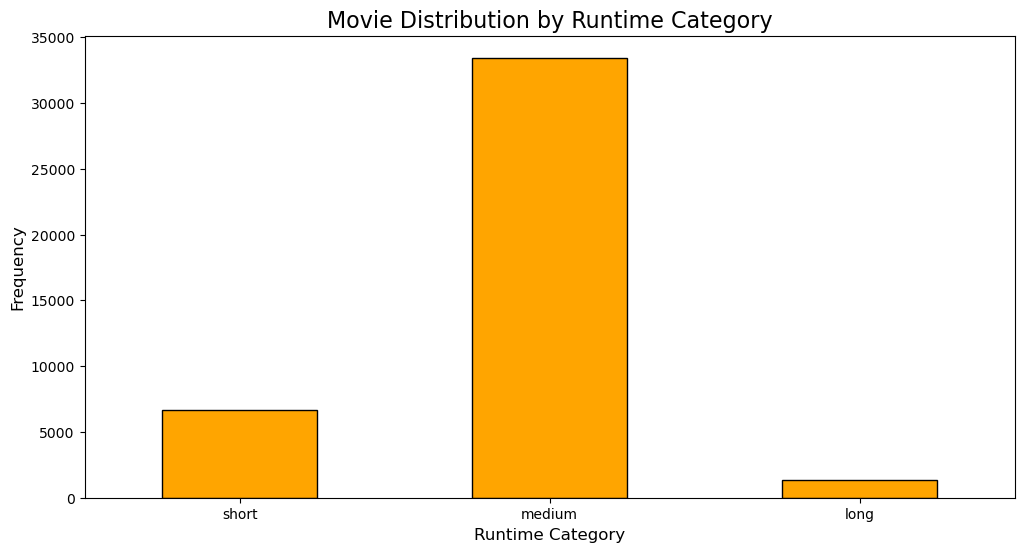

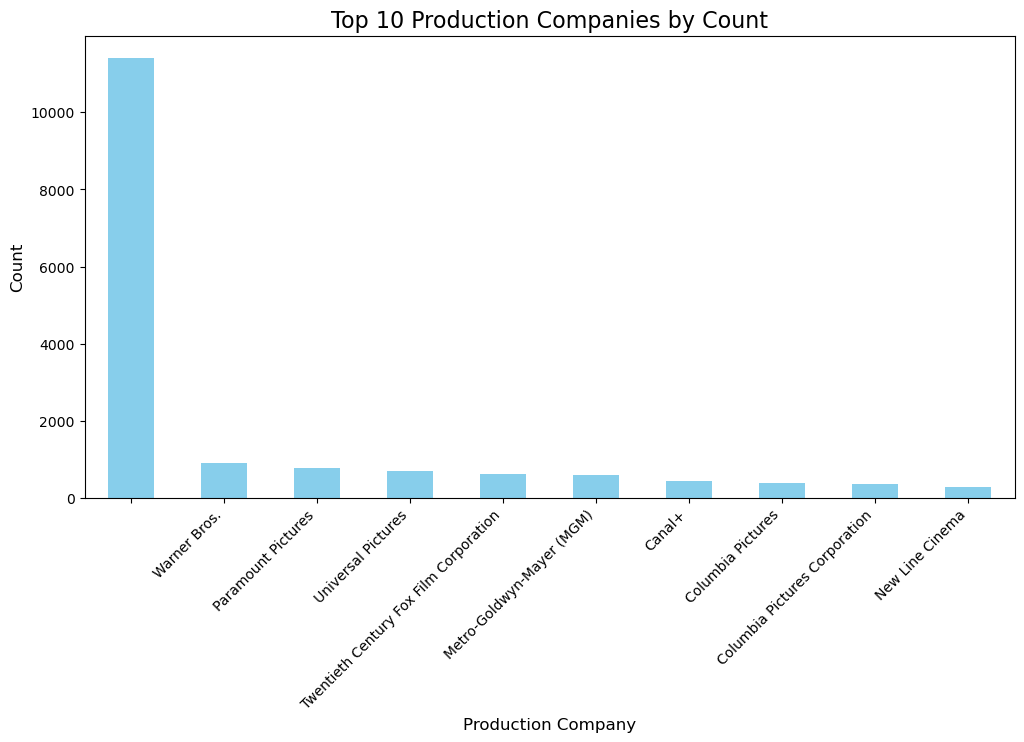

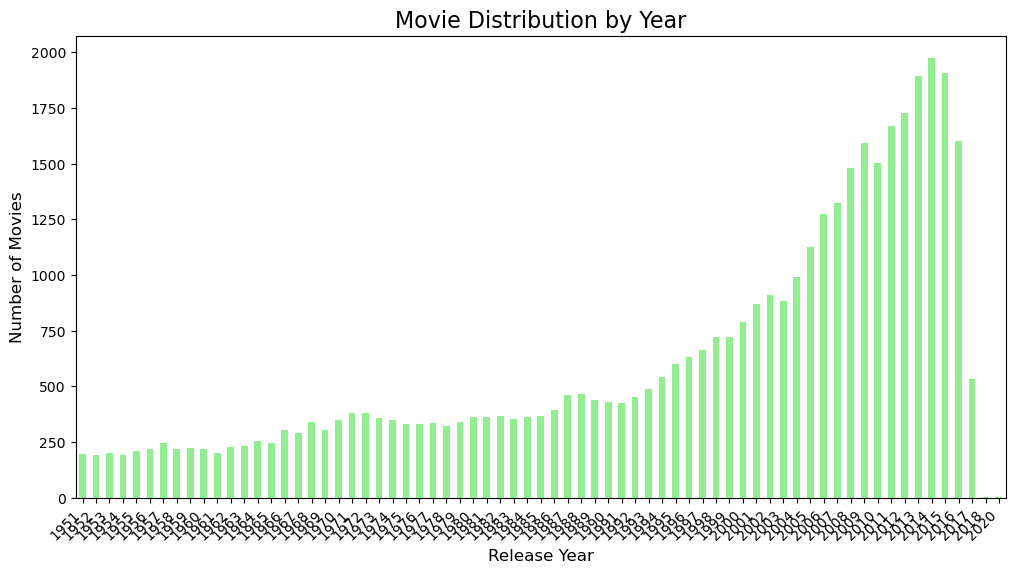

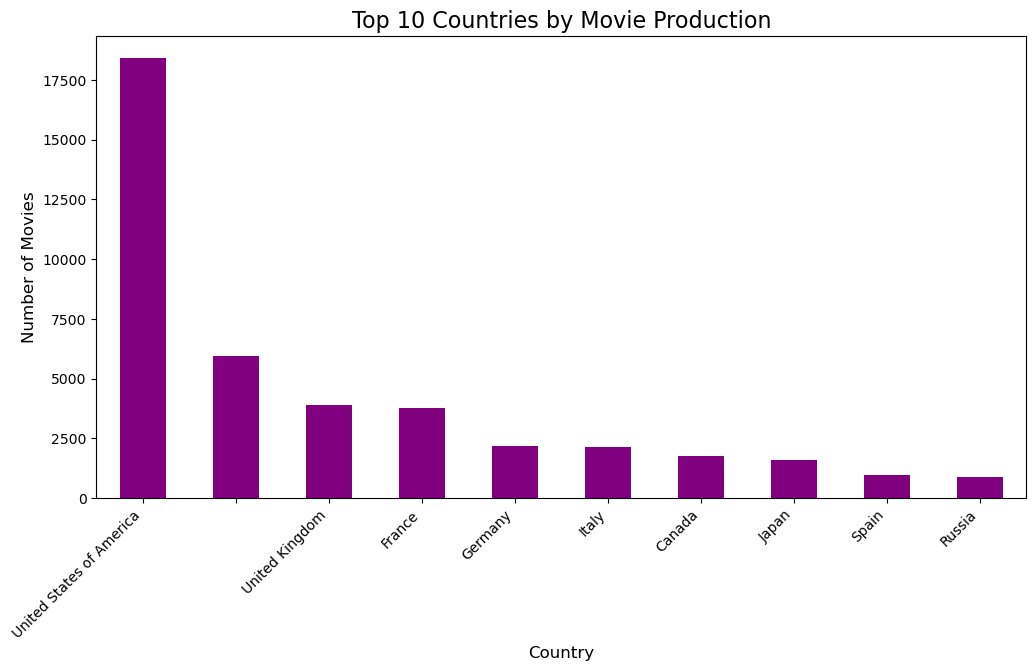

In [9]:
import matplotlib.pyplot as plt

# Function to count and plot production companies
def plot_production_company_distribution(data):
    production_companies = data['production_companies'].str.split('|').explode()
    company_counts = production_companies.value_counts().head(10)  # Top 10 companies

    plt.figure(figsize=(12, 6))
    company_counts.plot(kind='bar', color='skyblue')
    plt.title('Top 10 Production Companies by Count', fontsize=16)
    plt.xlabel('Production Company', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.show()

# Function to plot movie distribution by year
def plot_movie_distribution_by_year(data):
    plt.figure(figsize=(12, 6))
    data['release_year'].value_counts().sort_index().plot(kind='bar', color='lightgreen')
    plt.title('Movie Distribution by Year', fontsize=16)
    plt.xlabel('Release Year', fontsize=12)
    plt.ylabel('Number of Movies', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.show()



# Function to plot movie distribution by country
def plot_movie_distribution_by_country(data):
    countries = data['production_countries'].str.split('|').explode()
    country_counts = countries.value_counts().head(10)  # Top 10 countries

    plt.figure(figsize=(12, 6))
    country_counts.plot(kind='bar', color='purple')
    plt.title('Top 10 Countries by Movie Production', fontsize=16)
    plt.xlabel('Country', fontsize=12)
    plt.ylabel('Number of Movies', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.show()

# Function to plot movie distribution by runtime categories
def plot_movie_distribution_by_runtime_category(data):
    plt.figure(figsize=(12, 6))
    data['runtime_category'].value_counts().sort_index().plot(kind='bar', color='orange', edgecolor='black')
    plt.title('Movie Distribution by Runtime Category', fontsize=16)
    plt.xlabel('Runtime Category', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.xticks(rotation=0)  # Keep x-axis labels horizontal
    plt.show()

# Execute EDA visualizations for filtered_data
plot_movie_distribution_by_runtime_category(filtered_data)
plot_production_company_distribution(filtered_data)
plot_movie_distribution_by_year(filtered_data)
plot_movie_distribution_by_country(filtered_data)


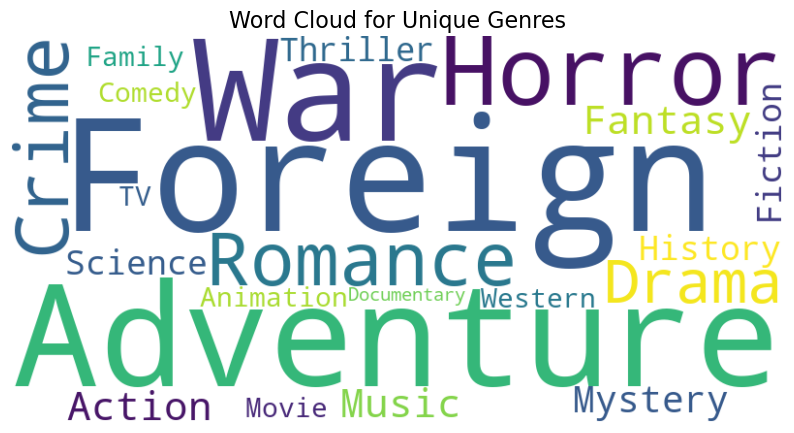

In [10]:
from wordcloud import WordCloud

# Combine all genres into a single string with unique values
unique_genres = set('|'.join(filtered_data['genres'].dropna()).split('|'))
all_genres_unique = ' '.join(unique_genres)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_genres_unique)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Unique Genres", fontsize=16)
plt.show()




## Embedding generation

In [11]:
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import MinMaxScaler
import faiss

# Preprocess Columns
def preprocess_cast_crew(column):
    """Replace '|' with underscores to preserve full names."""
    return column.str.replace('|', '_', regex=False)

def preprocess_other_columns(column):
    """Replace '|' with spaces for general multi-value columns."""
    return column.str.replace('|', ' ', regex=False)

# Combine Features into a Content Profile
def create_full_content_profile(row):
    """Combine relevant columns with adjusted weightage."""
    content = ' '.join([
        str(row['genres']) * 3,  # Higher weight for genres
        str(row['cast_names']) * 2,  # Higher weight for cast
        str(row['crew_names']),  # Default weight for crew
        str(row['original_language']),
        str(row['production_companies']),
        str(row['production_countries']),
        str(row['tagline']) if pd.notnull(row['tagline']) else '',  
        str(row['runtime_category']) if pd.notnull(row['runtime_category']) else ''  
    ])
    return content

# Apply preprocessing
filtered_data['cast_names'] = preprocess_cast_crew(filtered_data['cast_names'])
filtered_data['crew_names'] = preprocess_cast_crew(filtered_data['crew_names'])
filtered_data['genres'] = preprocess_other_columns(filtered_data['genres'])
filtered_data['production_companies'] = preprocess_other_columns(filtered_data['production_companies'])
filtered_data['production_countries'] = preprocess_other_columns(filtered_data['production_countries'])

# Create Content Profile
filtered_data['content_profile'] = filtered_data.apply(create_full_content_profile, axis=1)

# Generate Pre-Trained Embeddings
# Load pre-trained model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings for content profiles
filtered_data['content_embeddings'] = filtered_data['content_profile'].apply(lambda x: model.encode(x))

# Convert embeddings to a matrix
content_embeddings = np.array(filtered_data['content_embeddings'].tolist())

# Normalize Numerical Features
scaler = MinMaxScaler()
filtered_data[['vote_average_scaled', 'release_year_scaled']] = scaler.fit_transform(
    filtered_data[['vote_average', 'release_year']]
)

# Combine embeddings with numerical features
numerical_features_dense = filtered_data[['vote_average_scaled', 'release_year_scaled']].values
combined_features = np.hstack([content_embeddings, numerical_features_dense])

# Build FAISS Index
dimension = combined_features.shape[1]
index = faiss.IndexFlatL2(dimension)  # L2 distance index
index.add(combined_features)

# Build the Recommendation Function
def recommend_movies_faiss(title, data, index, feature_matrix, top_n=10):
    """Recommend top N similar movies using FAISS."""
    # Find the index of the movie with the given title
    indices = pd.Series(data.index, index=data['title']).drop_duplicates()
    if title not in indices:
        return "Movie title not found in dataset."
    idx = indices[title]

    # Query the FAISS index
    query_vector = feature_matrix[idx].reshape(1, -1)
    _, similar_indices = index.search(query_vector, top_n + 1)
    
    # Exclude the query movie itself
    similar_indices = similar_indices.flatten()[1:]
    
    return data['title'].iloc[similar_indices]




## Recommendation generation using FAISS

In [12]:
# Query the Recommendation System
movie_title = 'Toy Story'  # Replace with any movie title from dataset
recommended_movies = recommend_movies_faiss(movie_title, filtered_data, index, combined_features, top_n=5)
print("Recommended Movies for '{}':\n".format(movie_title), recommended_movies)

Recommended Movies for 'Toy Story':
 3002            Toy Story 2
4763         Monsters, Inc.
15378           Toy Story 3
11978    The Simpsons Movie
11395          Flushed Away
Name: title, dtype: object
